In [2]:
 # Step 1: Install rpy2
!pip install -q rpy2


# Step 2: Load the R magic
%load_ext rpy2.ipython



# **Parallelogram Optimizer**

In [ ]:
%%R
# Install and load the required packages
install.packages("ggplot2")
install.packages("pracma")
install.packages("R6")

library(pracma)
library(ggplot2)
library(R6)

[1] 21.92871 22.70139 17.51884


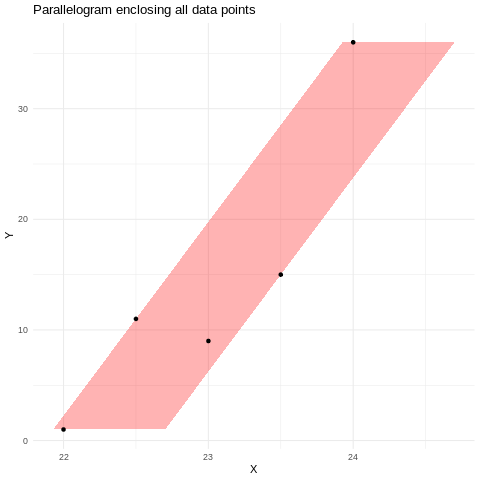

In [30]:
%%R


# Define the ParallelogramOptimizer class
ParallelogramOptimizer <- R6Class("ParallelogramOptimizer",
  public = list(
    x = NULL,
    y = NULL,
    y0 = NULL,
    y1 = NULL,
    params = NULL,

    initialize = function(x, y) {
      self$x <- x
      self$y <- y
      self$y0 <- min(y)
      self$y1 <- max(y)
      self$params <- NULL
    },

    get_corners = function(x0, y0, x1, y1, slope) {
      if (slope == 0) {
        lower_left <- c(x0, y0)
        lower_right <- c(x1, y0)
        upper_left <- c(x0, y1)
        upper_right <- c(x1, y1)
      } else {
        height <- y1 - y0
        delta_x <- height / slope

        if (abs(slope) > 1e3) {
          delta_x <- 0
        }

        lower_left <- c(x0, y0)
        lower_right <- c(x1, y0)
        upper_left <- c(x0 + delta_x, y1)
        upper_right <- c(x1 + delta_x, y1)
      }

      return(list(lower_left, lower_right, upper_right, upper_left))
    },

    constraints = function(params) {
      x0 <- params[1]
      x1 <- params[2]
      slope <- params[3]
      constraint_vals <- numeric()

      corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)
      lower_left <- corners[[1]]
      lower_right <- corners[[2]]
      upper_right <- corners[[3]]
      upper_left <- corners[[4]]

      for (i in seq_along(self$x)) {
        xi <- self$x[i]
        yi <- self$y[i]

        y_lower <- if (xi <= lower_right[1]) self$y0 else self$y0 + slope * (xi - lower_right[1])
        y_upper <- if (xi >= upper_left[1]) self$y1 else self$y1 + slope * (xi - upper_left[1])

        x_lower <- min(lower_left[1], upper_left[1])
        x_upper <- max(upper_right[1], lower_right[1])

        constraint_vals <- c(constraint_vals, y_upper - yi)
        constraint_vals <- c(constraint_vals, yi - y_lower)
        constraint_vals <- c(constraint_vals, xi - x_lower)
        constraint_vals <- c(constraint_vals, x_upper - xi)
      }
      return(constraint_vals)
    },

    objective = function(params) {
      x0 <- params[1]
      x1 <- params[2]
      slope <- params[3]
      corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)
      v1 <- corners[[2]] - corners[[1]]
      v2 <- corners[[4]] - corners[[1]]
      area <- abs(v1[1] * v2[2] - v1[2] * v2[1])

      c_penalty <- min(self$constraints(params))
      if (c_penalty > 0){
        c_penalty <- 0
      }
      return(area + 1e3 * c_penalty^2)
    },

    optimize_parallelogram = function() {
      x0_initial <- min(self$x)
      x1_initial <- max(self$x)
      slope_initial <- (self$y1 - self$y0) / (x1_initial - x0_initial)

      initial_guess <- c(x0_initial, x1_initial, slope_initial)

      result <- optim(
        par = initial_guess,
        fn = self$objective,
        method = "L-BFGS-B",
        lower = c(-Inf, -Inf, 0),
        upper = c(Inf, Inf, Inf)
      )

      self$params <- result$par
      return(self$params)
    },

    plot_parallelogram = function() {
      if (is.null(self$params)) {
        stop("Parameters are not optimized yet. Run optimize_parallelogram() first.")
      }

      x0 <- self$params[1]
      x1 <- self$params[2]
      slope <- self$params[3]

      corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)

      parallelogram_x <- c(corners[[1]][1], corners[[2]][1], corners[[3]][1], corners[[4]][1], corners[[1]][1])
      parallelogram_y <- c(corners[[1]][2], corners[[2]][2], corners[[3]][2], corners[[4]][2], corners[[1]][2])

      df <- data.frame(x = parallelogram_x, y = parallelogram_y)
      points_df <- data.frame(x = self$x, y = self$y)

      ggplot() +
        geom_polygon(data = df, aes(x = x, y = y), fill = "red", alpha = 0.3) +
        geom_point(data = points_df, aes(x = x, y = y)) +
        labs(title = "Parallelogram enclosing all data points", x = "X", y = "Y") +
        theme_minimal()

    }
  )
)

# Example usage
data_points <- matrix(c(22, 1, 22.5, 11, 23, 9, 23.5, 15, 24.0, 36), ncol = 2, byrow = TRUE)

# Create an instance of ParallelogramOptimizer
optimizer <- ParallelogramOptimizer$new(x = data_points[, 1], y = data_points[, 2])

# Optimize the parallelogram
params<-optimizer$optimize_parallelogram()
print(params)
# Plot the points and the parallelogram
optimizer$plot_parallelogram()


# **TODO**
- implement search for rise first?
- include assert in cleaning part

Data validation successful.
[1] "Warning: Descends across threshold at base segment index 1"
[1] "Warning: Large difference between nodes at base segment index 1"
[1] "Warning: Large difference between nodes at base segment index 2"
$x
 [1] 19.0 19.5 20.0 20.5 21.0 21.5 22.0 22.5 23.0 23.5 24.0 24.5 25.0 25.5

$y
 [1]  3.0  0.1  2.0  1.7  0.8  1.1  1.0 11.0  9.0 15.0 36.0 30.0 25.0 22.0

 [1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE
 [1] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE
trimmed data Values:
$x
 [1] 19.0 19.5 20.0 20.5 21.0 21.5 22.0 22.5 23.0 23.5 24.0 24.5 25.0 25.5

$y
 [1]  3.0  0.1  2.0  1.7  0.8  1.1  1.0 11.0  9.0 15.0 36.0 30.0 25.0 22.0

base seg X Values:
[1] 19.0 19.5 20.0 20.5 21.0 21.5
Base area X Values:
  xmin xmax ymin ymax
1 19.0 19.5 -Inf  Inf
2 19.5 20.0 -Inf  Inf
3 20.0 20.5 -Inf  Inf
4 20.5 21.0 -Inf  Inf
5 21.0 21.5 -Inf  Inf
6 21.5 22.0 -Inf  Inf
asc seg X Values:
[1] 22.0 

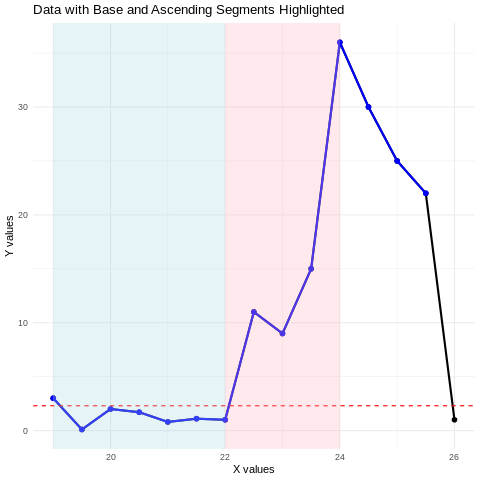

In [13]:
%%R

library(R6)
library(ggplot2)

# Define the R6 class
DataProcessor <- R6Class("DataProcessor",
  public = list(
    data = NULL,
    threshold = NULL,
    trimmed_data = NULL,
    base_segments = NULL,
    ascending_segments = NULL,

    # Constructor to initialize data and threshold
    initialize = function(data, threshold) {
      self$validate_data(data, threshold)
      self$data <- data
      self$threshold <- threshold
      self$trimmed_data <- self$clean_data()
      self$base_segments <- self$identify_base_segments()
      self$check_base_profile_consistency()
      self$ascending_segments <- self$identify_ascending_segments()
    },

    # Method to validate the data
    validate_data = function(data, threshold) {
      if (threshold <= 0) {
        stop("Threshold must be greater than 0.")
      }
      if (!("x" %in% names(data))) {
        stop("data should contain x")
      }
      if (!("y" %in% names(data))) {
        stop("data should contain y")
      }
      x <- data$x
      y <- data$y
      if (length(x) != length(y)) {
        stop("len(y) should be len(x)")
      }
      if (length(x) <= 2) {
        stop("insufficient data points")
      }
      if (max(y) < threshold) {
        stop(paste("at least one data point should be higher than the threshold:", threshold))
      }
      if (!all(x == sort(x))) {
        stop("input data is not chronological")
      }
      cat("Data validation successful.\n")
      return(TRUE)
    },

    # Method to clean data by filtering based on the threshold on y_values
    clean_data = function() {
      x_values <- self$data$x
      y_values <- self$data$y
      above_threshold <- which(y_values > self$threshold)
      if (length(above_threshold) == 0) {
        return(list(x = x_values, y = y_values))
      }
      last_above <- max(above_threshold)
      cleaned_x <- x_values[1:last_above]
      cleaned_y <- y_values[1:last_above]
      return(list(x = cleaned_x, y = cleaned_y))
    },

    # Method to calculate slopes between data points
    calculate_slopes = function(data) {
      y_values <- data$y
      slopes <- numeric(length(y_values) - 1)
      for (i in 1:(length(y_values) - 1)) {
        slopes[i] <- y_values[i + 1] - y_values[i]
      }
      return(slopes)
    },

    # Method to identify base segments
    identify_base_segments = function() {
      slopes <- self$calculate_slopes(self$trimmed_data)
      y_values <- self$trimmed_data$y
      base_segments <- logical(length(slopes))
      for (i in 1:length(slopes)) {
        if (slopes[i] <= 0 && (y_values[i] <= self$threshold || y_values[i + 1] <= self$threshold)) {
          base_segments[i] <- TRUE
        }
      }
      rightmost_base <- which(base_segments)
      if (length(rightmost_base) > 0) {
        base_segments[1:max(rightmost_base)] <- TRUE
      }
      return(base_segments)
    },

    # Method to check profile consistency for base segments only
    check_base_profile_consistency = function() {
      slopes <- self$calculate_slopes(self$trimmed_data)
      y_values <- self$trimmed_data$y
      base_segments <- self$base_segments

      for (i in which(base_segments)) {
        if (i < length(slopes)) {
          if (y_values[i] > self$threshold && y_values[i + 1] <= self$threshold) {
            print(paste("Warning: Descends across threshold at base segment index", i))
            warning("Profile consistency at base part: no (descends across threshold)")
          }
          if (abs(slopes[i]) > 0.5 * self$threshold) {
            print(paste("Warning: Large difference between nodes at base segment index", i))
            warning("Profile consistency at base part: no (large difference between nodes)")
          }
        }
      }
    },

# Method to identify the initial ascending segments
identify_ascending_segments = function() {
  x_values <- self$trimmed_data$x
  y_values <- self$trimmed_data$y
  ascending_segments <- logical(length(y_values) - 1)

  # Find the index where the data first crosses the threshold in an ascending manner
  start_index <- which(y_values > self$threshold & c(FALSE, diff(y_values) > 0))[1]

  if (!is.na(start_index)) {
    # Include the segment immediately before the first crossing
    if (start_index > 1) {
      ascending_segments[start_index - 1] <- TRUE
    }

    # Identify the ascending segments
    for (i in start_index:(length(y_values) - 1)) {
      if (y_values[i] > self$threshold) {
        ascending_segments[i] <- TRUE
      } else {
        break
      }
    }
  }

  return(ascending_segments)
},

truncate_ascending_segments = function(ascending_segments) {
  x_values <- self$trimmed_data$x
  y_values <- self$trimmed_data$y

  # Find the index of the last segment in the ascending region
  last_ascending_index <- max(which(ascending_segments))

  # Loop backwards from the end of the ascending region
  while (last_ascending_index > 1) {
    # Check if the last segment in the ascending region is ascending
    if (y_values[last_ascending_index + 1] > y_values[last_ascending_index]) {
      break  # Stop if the last segment is positively sloped
    }

    # Truncate the last segment from ascending segments
    ascending_segments[last_ascending_index] <- FALSE

    # Update the index of the last ascending segment
    last_ascending_index <- last_ascending_index - 1
  }

  return(ascending_segments)
}
,

    # Method to plot the raw data, base segments, and ascending segments
    plot_data_with_segments = function() {
      x_values <- self$data$x
      y_values <- self$data$y
      trimmed_x <- self$trimmed_data$x
      trimmed_y <- self$trimmed_data$y

      base_segments <- self$base_segments

      ascending_segments <- self$identify_ascending_segments()
      ascending_segments <- self$truncate_ascending_segments(ascending_segments)

      plot_data <- data.frame(x = x_values, y = y_values)
      trimmed_plot_data <- data.frame(x = trimmed_x, y = trimmed_y)
      cat("trimmed data Values:\n")
      print(self$trimmed_data)

      # Create shaded areas for base and ascending segments
      shaded_area_data_base <- data.frame(
        xmin = numeric(),
        xmax = numeric(),
        ymin = numeric(),
        ymax = numeric()
      )

      shaded_area_data_ascending <- data.frame(
        xmin = numeric(),
        xmax = numeric(),
        ymin = numeric(),
        ymax = numeric()
      )

      if (any(base_segments)) {
        cat("base seg X Values:\n")
        print(self$trimmed_data$x[which(base_segments)])
        for (i in which(base_segments)) {
          shaded_area_data_base <- rbind(shaded_area_data_base, data.frame(
            xmin = self$trimmed_data$x[i],
            xmax = self$trimmed_data$x[i + 1],
            ymin = -Inf,  # Use -Inf to extend the shaded area to the bottom of the plot
            ymax = Inf    # Use Inf to extend the shaded area to the top of the plot
          ))
        }
        shaded_area_data_base <- shaded_area_data_base[order(shaded_area_data_base$xmin),]
        cat("Base area X Values:\n")
        print(shaded_area_data_base)
      }

      if (any(ascending_segments)) {
        cat("asc seg X Values:\n")
        print(self$trimmed_data$x[which(ascending_segments)])
        for (i in which(ascending_segments)) {
          shaded_area_data_ascending <- rbind(shaded_area_data_ascending, data.frame(
            xmin = self$trimmed_data$x[i],
            xmax = self$trimmed_data$x[i + 1],
            ymin = -Inf,  # Use -Inf to extend the shaded area to the bottom of the plot
            ymax = Inf    # Use Inf to extend the shaded area to the top of the plot
          ))
        }
        shaded_area_data_ascending <- shaded_area_data_ascending[order(shaded_area_data_ascending$xmin),]
        cat("Ascending area X Values:\n")
        print(shaded_area_data_ascending)
      }

      # Initialize the ggplot object
      p <- ggplot() +
        geom_line(data = plot_data, aes(x = x, y = y), color = "black", size = 1) +
        geom_point(data = plot_data, aes(x = x, y = y), color = "black", size = 2) +
        geom_line(data = trimmed_plot_data, aes(x = x, y = y), color = "blue", size = 1) +
        geom_point(data = trimmed_plot_data, aes(x = x, y = y), color = "blue", size = 2) +
        geom_hline(yintercept = self$threshold, linetype = "dashed", color = "red") +
        labs(title = "Data with Base and Ascending Segments Highlighted", x = "X values", y = "Y values") +
        theme_minimal()

      # Overlay shaded areas behind base segments and ascending segments
      if (nrow(shaded_area_data_base) > 0) {
        p <- p + geom_rect(data = shaded_area_data_base, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = "lightblue", alpha = 0.3, color = NA)
      }
      if (nrow(shaded_area_data_ascending) > 0) {
        p <- p + geom_rect(data = shaded_area_data_ascending, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = "lightpink", alpha = 0.3, color = NA)
      }

      print(p)

      # After identifying base segments
      cat("Base Segment X Values:\n")
      print(self$trimmed_data$x[self$base_segments])

      # After identifying ascending segments
      cat("Ascending Segment X Values:\n")
      print(self$trimmed_data$x[self$ascending_segments])

    }
  )
)

# Example usage:
all_data <- list(
  x = c(19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5,26),
  y = c(3,0.1, 2.0, 1.7, 0.8, 1.1, 1, 11,9, 15, 36, 30, 25, 22, 1)
)

threshold <- 2.3

# Create an instance of the DataProcessor class
processor <- DataProcessor$new(all_data, threshold)

# Clean data based on threshold
trimmed_data <- processor$clean_data()
print(trimmed_data)

# Check segments for consistency and base part identification
base_parts <- processor$base_segments
print(base_parts)

# Identify ascending segments
ascending_segments <- processor$ascending_segments
print(ascending_segments)

# Plot the raw data with base and ascending segments highlighted
processor$plot_data_with_segments()




Data validation successful.
[1] "Warning: Descends across threshold at base segment index 1"
[1] "Warning: Large difference between nodes at base segment index 1"
[1] "Warning: Large difference between nodes at base segment index 2"
[1] "Warning: Large difference between nodes at base segment index 7"
***1*** trimmed data$x
 [1] 19.0 19.5 20.0 20.5 21.0 21.5 22.0 22.5 23.0 23.5 24.0 24.5 25.0 25.5

$y
 [1]  5.0  0.1  2.0  1.7  0.8  1.1  1.0 11.0  9.0 15.0 36.0 36.5 38.0 22.0

***2*** base data [1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE
[1] 19.0 19.5 20.0 20.5 21.0 21.5 22.0
***3*** ascend data [1] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE
[1] 22.0 22.5 23.0 23.5 24.0 24.5 25.0
***4*** truncated asecnd data [1] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE
[1] 22.0 22.5 23.0 23.5 24.0 24.5 25.0
Base!!
[1] 19.0 19.5 20.0 20.5 21.0 21.5 22.0
Truncated Data:
     

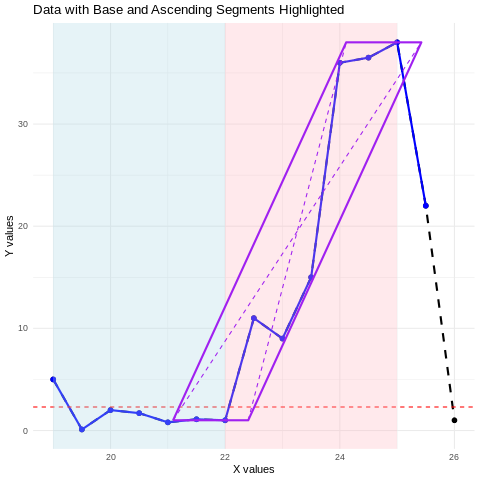

In [63]:
%%R
library(R6)
library(ggplot2)

# Define the ParallelogramOptimizer class
ParallelogramOptimizer <- R6Class("ParallelogramOptimizer",
  public = list(
    x = NULL,
    y = NULL,
    y0 = NULL,
    y1 = NULL,
    params = NULL,

    initialize = function(x, y) {
      self$x <- x
      self$y <- y
      self$y0 <- min(y)
      self$y1 <- max(y)
      self$params <- NULL
    },

    get_corners = function(x0, y0, x1, y1, slope) {
      if (slope == 0) {
        lower_left <- c(x0, y0)
        lower_right <- c(x1, y0)
        upper_left <- c(x0, y1)
        upper_right <- c(x1, y1)
      } else {
        height <- y1 - y0
        delta_x <- height / slope

        if (abs(slope) > 1e3) {
          delta_x <- 0
        }

        lower_left <- c(x0, y0)
        lower_right <- c(x1, y0)
        upper_left <- c(x0 + delta_x, y1)
        upper_right <- c(x1 + delta_x, y1)
      }

      return(list(lower_left, lower_right, upper_right, upper_left))
    },

    constraints = function(params) {
      x0 <- params[1]
      x1 <- params[2]
      slope <- params[3]
      constraint_vals <- numeric()

      corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)
      lower_left <- corners[[1]]
      lower_right <- corners[[2]]
      upper_right <- corners[[3]]
      upper_left <- corners[[4]]

      for (i in seq_along(self$x)) {
        xi <- self$x[i]
        yi <- self$y[i]

        y_lower <- if (xi <= lower_right[1]) self$y0 else self$y0 + slope * (xi - lower_right[1])
        y_upper <- if (xi >= upper_left[1]) self$y1 else self$y1 + slope * (xi - upper_left[1])

        x_lower <- min(lower_left[1], upper_left[1])
        x_upper <- max(upper_right[1], lower_right[1])

        constraint_vals <- c(constraint_vals, y_upper - yi)
        constraint_vals <- c(constraint_vals, yi - y_lower)
        constraint_vals <- c(constraint_vals, xi - x_lower)
        constraint_vals <- c(constraint_vals, x_upper - xi)
      }
      return(constraint_vals)
    },

    objective = function(params) {
      x0 <- params[1]
      x1 <- params[2]
      slope <- params[3]
      corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)
      v1 <- corners[[2]] - corners[[1]]
      v2 <- corners[[4]] - corners[[1]]
      area <- abs(v1[1] * v2[2] - v1[2] * v2[1])

      c_penalty <- min(self$constraints(params))
      if (c_penalty > 0){
        c_penalty <- 0
      }
      return(area + 1e3 * c_penalty^2)
    },

    optimize_parallelogram = function() {
      x0_initial <- min(self$x)
      x1_initial <- max(self$x)
      slope_initial <- (self$y1 - self$y0) / (x1_initial - x0_initial)

      initial_guess <- c(x0_initial, x1_initial, slope_initial)

      result <- optim(
        par = initial_guess,
        fn = self$objective,
        method = "L-BFGS-B",
        lower = c(-Inf, -Inf, 0),
        upper = c(Inf, Inf, Inf)
      )

      self$params <- result$par
      return(self$params)
    },

plot_parallelogram = function(existing_plot = NULL, params = NULL) {
  # Use the provided params or fall back to self$params
  if (is.null(params)) {
    if (is.null(self$params)) {
      stop("Parameters are not optimized yet. Run parallelogram_truncation() first.")
    }
    params <- self$params
  }

  x0 <- params[1]
  x1 <- params[2]
  slope <- params[3]

  corners <- self$get_corners(x0, self$y0, x1, self$y1, slope)

  parallelogram_x <- c(corners[[1]][1], corners[[2]][1], corners[[3]][1], corners[[4]][1], corners[[1]][1])
  parallelogram_y <- c(corners[[1]][2], corners[[2]][2], corners[[3]][2], corners[[4]][2], corners[[1]][2])

  df <- data.frame(x = parallelogram_x, y = parallelogram_y)

  if (is.null(existing_plot)) {
    stop("No existing plot provided for overlay.")
  }

  # Overlay parallelogram on existing plot
  p <- existing_plot +
    geom_path(data = df, aes(x = x, y = y), color = "purple", size = 1) +
    geom_segment(aes(x = corners[[1]][1], y = corners[[1]][2], xend = corners[[3]][1], yend = corners[[3]][2]),
                 color = "purple", linetype = "dashed") +
    geom_segment(aes(x = corners[[2]][1], y = corners[[2]][2], xend = corners[[4]][1], yend = corners[[4]][2]),
                 color = "purple", linetype = "dashed")

  print(p)
}
  )
)

# Define the DataProcessor class
DataProcessor <- R6Class("DataProcessor",
  public = list(
    data = NULL,
    threshold = NULL,
    trimmed_data = NULL,
    base_segments = NULL,
    ascending_segments = NULL,
    parallelogram_optimizer = NULL,

    # Constructor to initialize data and threshold
    initialize = function(data, threshold) {
      self$validate_data(data, threshold)
      self$data <- data
      self$threshold <- threshold
      self$trimmed_data <- self$clean_data()
      self$base_segments <- self$identify_base_segments()
      self$check_base_profile_consistency()
      self$ascending_segments <- self$identify_ascending_segments()
    },

    # Method to validate the data
    validate_data = function(data, threshold) {
      if (threshold <= 0) {
        stop("Threshold must be greater than 0.")
      }
      if (!("x" %in% names(data))) {
        stop("data should contain x")
      }
      if (!("y" %in% names(data))) {
        stop("data should contain y")
      }
      x <- data$x
      y <- data$y
      if (length(x) != length(y)) {
        stop("len(y) should be len(x)")
      }
      if (length(x) <= 2) {
        stop("insufficient data points")
      }
      if (max(y) < threshold) {
        stop(paste("at least one data point should be higher than the threshold:", threshold))
      }
      if (!all(x == sort(x))) {
        stop("input data is not chronological")
      }
      cat("Data validation successful.\n")
      return(TRUE)
    },

    # Method to clean data by filtering based on the threshold on y_values
    clean_data = function() {
      x_values <- self$data$x
      y_values <- self$data$y
      above_threshold <- which(y_values > self$threshold)
      if (length(above_threshold) == 0) {
        return(list(x = x_values, y = y_values))
      }
      last_above <- max(above_threshold)
      cleaned_x <- x_values[1:last_above]
      cleaned_y <- y_values[1:last_above]
      return(list(x = cleaned_x, y = cleaned_y))
    },

    # Method to calculate slopes between data points
    calculate_slopes = function(data) {
      y_values <- data$y
      slopes <- numeric(length(y_values) - 1)
      for (i in 1:(length(y_values) - 1)) {
        slopes[i] <- y_values[i + 1] - y_values[i]
      }
      return(slopes)
    },

    # Method to identify base segments
    identify_base_segments = function() {
      slopes <- self$calculate_slopes(self$trimmed_data)
      y_values <- self$trimmed_data$y
      base_segments <- logical(length(slopes)+1)
      for (i in 1:length(slopes)) {
        if (slopes[i] <= 0 && (y_values[i] <= self$threshold || y_values[i + 1] <= self$threshold)) {
          base_segments[i] <- TRUE
        }
      }
      rightmost_base <- which(base_segments)
      if (length(rightmost_base) > 0) {
        base_segments[1:max(rightmost_base)+1] <- TRUE
      }
      return(base_segments)
    },

    # Method to check profile consistency for base segments only
    check_base_profile_consistency = function() {
      slopes <- self$calculate_slopes(self$trimmed_data)
      y_values <- self$trimmed_data$y
      base_segments <- self$base_segments
      for (i in which(base_segments)) {
        if (y_values[i] > self$threshold && y_values[i + 1] <= self$threshold) {
          print(paste("Warning: Descends across threshold at base segment index", i))
          warning("Profile consistency at base part: no (descends across threshold)")
        }
        if (abs(slopes[i]) > 0.5 * self$threshold) {
          print(paste("Warning: Large difference between nodes at base segment index", i))
          warning("Profile consistency at base part: no (large difference between nodes)")
        }
      }
    },

    # Method to identify the initial ascending segments
    identify_ascending_segments = function() {
      x_values <- self$trimmed_data$x
      y_values <- self$trimmed_data$y
      ascending_segments <- logical(length(y_values) - 1)

      # Find the index where the data first crosses the threshold in an ascending manner
      start_index <- which(y_values > self$threshold & c(FALSE, diff(y_values) > 0))[1]

      if (!is.na(start_index)) {
        # Include the segment immediately before the first crossing
        if (start_index > 1) {
          ascending_segments[start_index - 1] <- TRUE
        }

        # Identify the ascending segments
        for (i in start_index:(length(y_values) - 1)) {
          if (y_values[i] > self$threshold) {
            ascending_segments[i] <- TRUE
          } else {
            break
          }
        }
      }

      return(ascending_segments)
    },

    # Method to truncate ascending segments
    truncate_ascending_segments = function(ascending_segments) {
      x_values <- self$trimmed_data$x
      y_values <- self$trimmed_data$y

      # Find the index of the last segment in the ascending region
      last_ascending_index <- max(which(ascending_segments))

      # Loop backwards from the end of the ascending region
      while (last_ascending_index > 1) {
        # Check if the last segment in the ascending region is ascending
        if (y_values[last_ascending_index + 1] > y_values[last_ascending_index]) {
          ascending_segments[last_ascending_index+1]<- TRUE
          break  # Stop if the last segment is positively sloped
        }

        # Truncate the last segment from ascending segments
        ascending_segments[last_ascending_index] <- FALSE

        # Update the index of the last ascending segment
        last_ascending_index <- last_ascending_index - 1
      }

      return(ascending_segments)
    },

    # Method to plot the raw data, base segments, and ascending segments
    plot_data_with_segments = function() {
      x_values <- self$data$x
      y_values <- self$data$y
      trimmed_x <- self$trimmed_data$x
      trimmed_y <- self$trimmed_data$y

      base_segments <- self$base_segments
      cat("Base!!\n")
      print(trimmed_x[base_segments])
      ascending_segments <- self$identify_ascending_segments()
      truncated_ascending_segments <- self$truncate_ascending_segments(ascending_segments)

      plot_data <- data.frame(x = x_values, y = y_values)
      trimmed_plot_data <- data.frame(x = trimmed_x, y = trimmed_y)

      # Create shaded areas for base and ascending segments
      shaded_area_data_base <- data.frame(
        xmin = numeric(),
        xmax = numeric(),
        ymin = numeric(),
        ymax = numeric()
      )

      shaded_area_data_ascending <- data.frame(
        xmin = numeric(),
        xmax = numeric(),
        ymin = numeric(),
        ymax = numeric()
      )

      #if (any(base_segments)) {
      #  for (i in which(base_segments)) {
      #    shaded_area_data_base <- rbind(shaded_area_data_base, data.frame(
      #      xmin = self$trimmed_data$x[i],
      #      xmax = self$trimmed_data$x[i+1],
      #      ymin = -Inf,  # Use -Inf to extend the shaded area to the bottom of the plot
      #      ymax = Inf    # Use Inf to extend the shaded area to the top of the plot
      #    ))
      #  }
      #  shaded_area_data_base <- shaded_area_data_base[order(shaded_area_data_base$xmin),]
      #}
      if (any(base_segments)){

# Find the indices of the first and last TRUE elements
first_true <- which.max(base_segments)
last_true <- tail(which(base_segments), 1)

# Create a data frame for the shaded area
  shaded_area_data_base <- data.frame(
  xmin = self$trimmed_data$x[first_true],
  xmax = self$trimmed_data$x[last_true],  # Use last_true + 1 to get the right boundary
  ymin = -Inf,
  ymax = Inf
  )
  # Sort by xmin
shaded_area_data_base <- shaded_area_data_base[order(shaded_area_data_base$xmin),]

      }
      #if (any(truncated_ascending_segments)) {
      #  for (i in which(truncated_ascending_segments)) {
      #    shaded_area_data_ascending <- rbind(shaded_area_data_ascending, data.frame(
      #      xmin = self$trimmed_data$x[i],
      #      xmax = self$trimmed_data$x[i+1],
      #      ymin = -Inf,  # Use -Inf to extend the shaded area to the bottom of the plot
      #      ymax = Inf    # Use Inf to extend the shaded area to the top of the plot
      #    ))
      #  }
      #  shaded_area_data_ascending <- shaded_area_data_ascending[order(shaded_area_data_ascending$xmin),]
      #}

      if (any(truncated_ascending_segments)){

# Find the indices of the first and last TRUE elements
first_true <- which.max(truncated_ascending_segments)
last_true <- tail(which(truncated_ascending_segments), 1)

# Create a data frame for the shaded area
  shaded_area_data_ascending <- data.frame(
  xmin = self$trimmed_data$x[first_true],
  xmax = self$trimmed_data$x[last_true],  # Use last_true + 1 to get the right boundary
  ymin = -Inf,
  ymax = Inf
  )
  # Sort by xmin
shaded_area_data_ascending <- shaded_area_data_ascending[order(shaded_area_data_ascending$xmin),]

      }

      # Initialize the ggplot object
      p <- ggplot() +
        geom_line(data = plot_data, aes(x = x, y = y), linetype = "dashed", color = "black", size = 1) +
        geom_point(data = plot_data, aes(x = x, y = y), color = "black", size = 2) +
        geom_line(data = trimmed_plot_data, aes(x = x, y = y), color = "blue", size = 1) +
        geom_point(data = trimmed_plot_data, aes(x = x, y = y), color = "blue", size = 2) +
        geom_hline(yintercept = self$threshold, linetype = "dashed", color = "red") +
        labs(title = "Data with Base and Ascending Segments Highlighted", x = "X values", y = "Y values") +
        theme_minimal()

      # Overlay shaded areas behind base segments and ascending segments
      if (nrow(shaded_area_data_base) > 0) {
        p <- p + geom_rect(data = shaded_area_data_base, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = "lightblue", alpha = 0.3, color = NA)
      }
      if (nrow(shaded_area_data_ascending) > 0) {
        p <- p + geom_rect(data = shaded_area_data_ascending, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = "lightpink", alpha = 0.3, color = NA)
      }

      #print(p)
      return(p)

      # After identifying base segments
      cat("Base Segment X Values:\n")
      #print(self$trimmed_data$x[self$base_segments])
      print(self$trimmed_data$x[base_segments])

      # After identifying ascending segments
      cat("Ascending Segment X Values:\n")
      print(self$trimmed_data$x[truncated_ascending_segments])
    },

    # Method to perform parallelogram truncation on truncated ascending segment data
    parallelogram_truncation = function() {
      ascending_segments <- self$truncate_ascending_segments(self$ascending_segments)
      x_values <- self$trimmed_data$x[ascending_segments]
      y_values <- self$trimmed_data$y[ascending_segments]

      #optimizer <- ParallelogramOptimizer$new(
        #x = x_values,
       # y = y_values
      #)
         # Create an instance of ParallelogramOptimizer and store it
      self$parallelogram_optimizer <- ParallelogramOptimizer$new(
        x = x_values,
        y = y_values
      )

        # Print truncated data to verify correctness
        cat("Truncated Data:\n")
        print(data.frame(x = x_values, y = y_values))

      #params <- optimizer$optimize_parallelogram()
      params <- self$parallelogram_optimizer$optimize_parallelogram()
        # Plot and ensure it renders
      #cat("Plotting the parallelogram...\n")
      #optimizer$plot_parallelogram()

      cat("Parallelogram Parameters:\n")
      print(params)
      return(params)
    },

    # Method to plot parallelogram
    plot_parallelogram = function(existing_plot = NULL, params = NULL) {
      # Check if the optimizer is available
      if (is.null(self$parallelogram_optimizer)) {
        stop("ParallelogramOptimizer instance is not available. Run parallelogram_truncation() first.")
      }

      # Plot the parallelogram using the stored optimizer

      self$parallelogram_optimizer$plot_parallelogram(existing_plot, params)
    }


  )
)

# Example usage:
all_data <- list(
  x = c(19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5,26),
  y = c(5,0.1, 2.0, 1.7, 0.8, 1.1, 1, 11,9, 15, 36, 36.5, 38, 22, 1)
)

threshold <- 2.3

# Create an instance of the DataProcessor class
processor <- DataProcessor$new(all_data, threshold)

# Clean data based on threshold
trimmed_data <- processor$clean_data()
cat("***1*** trimmed data")
print(trimmed_data)


# Check segments for consistency and base part identification
base_parts <- processor$base_segments
cat("***2*** base data")
print(base_parts)
print(trimmed_data$x[base_parts])

# Identify ascending segments
ascending_segments <- processor$ascending_segments
cat("***3*** ascend data")
print(ascending_segments)
print(trimmed_data$x[ascending_segments])

# Truncate the ascending segments on the right
truncated_ascending_segments <- processor$truncate_ascending_segments(ascending_segments)
cat("***4*** truncated asecnd data")
print(truncated_ascending_segments)
print(trimmed_data$x[truncated_ascending_segments])

# Plot the raw data with base and ascending segments highlighted
base_plot<-processor$plot_data_with_segments()

# Perform parallelogram truncation on the truncated ascending segments and plot the parallelogram
params <- processor$parallelogram_truncation()

# overlay parallelogram plot
#processor$parallelogram_optimizer$plot_parallelogram(params)
#processor$plot_parallelogram(params)
#processor$parallelogram_optimizer$plot_parallelogram(params)
processor$plot_parallelogram(existing_plot = base_plot, params = params)